In [2]:
import torch
import torch.distributions as D
import torch.nn as nn
import numpy as np

from optimal_transport import OTPlanSampler

%matplotlib inline
from matplotlib import pyplot as plt

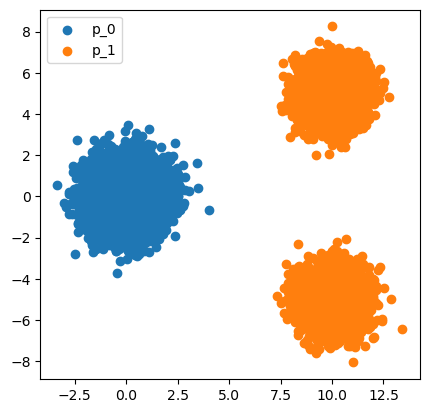

In [4]:
def build_gmm(n_modes, means=None, vars=None):

    if means is None:
        means = torch.randn(n_modes,2)
    if vars is None:
        vars = torch.rand(n_modes,2)
        vars[:,1] = vars[:,0]

    mix = D.Categorical(torch.ones(n_modes,))
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm


p_0_means = torch.zeros(2)
p_0_vars = torch.ones(2)*0.75
p_0 = D.MultivariateNormal(p_0_means, torch.diag(p_0_vars))


p_1_means = torch.tensor([[10,5], [10,-5]]).float()
p_1_vars = torch.ones(2,2)*0.75
p_1 = build_gmm(2, p_1_means, p_1_vars)

samples = p_0.sample((10000,))
plt.scatter(samples[:, 0], samples[:, 1], label='p_0')


samples = p_1.sample((10000,))
plt.scatter(samples[:, 0], samples[:, 1], label='p_1')
plt.gca().set_aspect('equal', adjustable='box')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.legend()
plt.show()


# train vector field

Final loss = 0.92


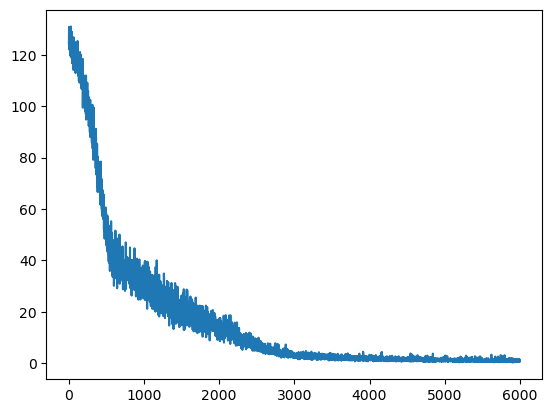

In [47]:
def train_flow_matching_model(n_iterations, batch_size, p_0, p_1, learning_rate=1.0e-4, sigma=0.1, use_ot=False):
    u = nn.Sequential(
        nn.Linear(3, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.ReLU(),
        nn.Linear(15, 2)
    )

    # intitalize adam optimizer
    optimizer = torch.optim.Adam(u.parameters(), lr=learning_rate)

    if use_ot:
        ot_sampler = OTPlanSampler()

    losses = []

    for iter_idx in range(n_iterations):

        # zero out gradients
        optimizer.zero_grad()

        x_0 = p_0.sample((batch_size,))
        x_1 = p_1.sample((batch_size,))

        if use_ot:
            x_0, x_1 = ot_sampler.sample_plan(x_0, x_1)

        # sample time
        t = torch.rand(batch_size,)

        # construct x_t
        mu_x_t = x_0 + t[:,None]*(x_1 - x_0)
        sigma_x_t = sigma*torch.ones_like(mu_x_t)
        x_t = mu_x_t + sigma_x_t*torch.randn_like(mu_x_t)

        # compute true conditional vectors
        u_true = x_1 - x_0

        # predict conditional vectors
        u_pred = u(torch.cat((x_t, t[:,None]), dim=-1))

        # compute loss
        loss = torch.square(u_true - u_pred).sum(dim=1).mean()

        # compute gradients
        loss.backward()

        # update parameters
        optimizer.step()


        losses.append(loss.item())
    
    return losses, u

losses, u = train_flow_matching_model(n_iterations=int(6e3), batch_size=50, p_0=p_0, p_1=p_1, learning_rate=1.0e-4, sigma=0.01, use_ot=True)

# print the average loss in the last 100 iterations
print(f'Final loss = {np.mean(losses[-100:]):.2f}')

plt.plot(losses)
plt.show()

# integrate vector field

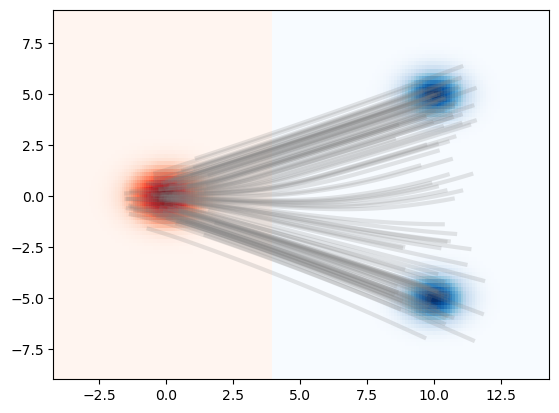

In [48]:
@torch.no_grad()
def integrate_u(x_0, u, n_steps=100):
    """Use Euler integration to integrate the time-varying vector field u from 0 to 1"""

    # x_0 is a tensor of shape (batch_size, 2) containing the initial positions
    # u is a time varying vector field (the trained neural network)
    # n_steps is the number of integration steps to run
    batch_size = x_0.shape[0]
    t = torch.linspace(0, 1, n_steps)
    dt = t[1] - t[0]
    x_t = torch.zeros(*x_0.shape, n_steps, dtype=x_0.dtype) # state, has shape (batch_size, 2, n_steps)
    x_t[:,:,0] = x_0
    for step_idx in range(n_steps-1):
        current_state = x_t[:, :, step_idx]
        u_input = torch.cat((current_state, t[step_idx]*torch.ones(batch_size, 1)), dim=-1)
        x_t[:, :, step_idx+1] = current_state + dt*u(u_input)
    return t, x_t

def make_density_plot(dist, xlim, ylim, n_points=100, cmap='Reds', alpha=0.75):
    # plot p_0 and p_1 densities on a mesh grid
    x = torch.linspace(*xlim, n_points)
    y = torch.linspace(*ylim, n_points)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack((X.flatten(), Y.flatten()), dim=-1)
    density = torch.exp(dist.log_prob(grid)).reshape(n_points,n_points)
    plt.pcolormesh(X, Y, density, cmap=cmap, alpha=alpha)


make_density_plot(dist=p_0, xlim=(xlim[0], 4), ylim=ylim, cmap='Reds', alpha=1.0)
make_density_plot(dist=p_1, xlim=(4, xlim[1]), ylim=ylim, cmap='Blues', alpha=1.0)


n_trajectories = 100
x_0 = p_0.sample((n_trajectories,))
t, x_t = integrate_u(x_0, u, n_steps=100)

for traj_idx in range(n_trajectories):
    plt.plot(x_t[traj_idx,0,:], x_t[traj_idx,1,:], alpha=0.2 , lw=3, color='gray')

    
# plt.gca().set_aspect('equal', )
plt.show()

# visualize time-varying vector field

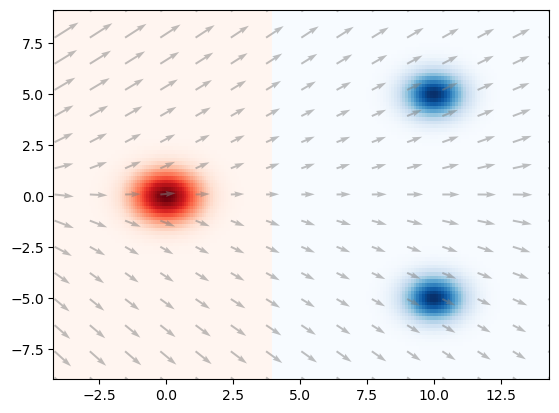

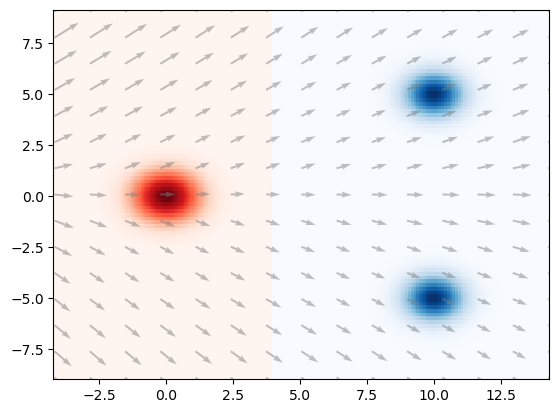

In [46]:
def make_vector_field_plot(u, t: float, xlim, ylim, n_points=15):
    # plot p_0 and p_1 densities on a mesh grid
    x = torch.linspace(*xlim, n_points)
    y = torch.linspace(*ylim, n_points)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack((X.flatten(), Y.flatten()), dim=-1)
    vecs = u(torch.cat((grid, t*torch.ones(grid.shape[0], 1)), dim=-1)).reshape(n_points,n_points,2)
    
    # convert X, Y, vecs to numpy arrays
    X = X.detach().numpy()
    Y = Y.detach().numpy()
    vecs = vecs.detach().numpy()
    plt.quiver(X, Y, vecs[:,:,0], vecs[:,:,1], color='gray', alpha=0.5)


for t in [0.1, 0.9]:

    make_density_plot(dist=p_0, xlim=(xlim[0], 4), ylim=ylim, cmap='Reds', alpha=1.0)
    make_density_plot(dist=p_1, xlim=(4, xlim[1]), ylim=ylim, cmap='Blues', alpha=1.0)

    make_vector_field_plot(u, t=t, xlim=xlim, ylim=ylim)
    plt.show()